In [1]:
import numpy as np
import pandas as pd
import json
import collections 
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from keras.models import Model
from keras.layers import Input, Dense, Embedding, concatenate, Flatten, Activation, Add, Dropout, Multiply
import seaborn as sns
from sklearn.metrics import mean_absolute_error

from keras.optimizers import adam_v2


In [2]:
data =pd.read_csv('/kaggle/input/amazon-product-ratings/ratings_Beauty.csv', names = ["userId", "ProductId", "Ratings", "Timestamp"])
data.head(15)

,userId,ProductId,Ratings,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
5,AKJHHD5VEH7VG,0762451459,5.0,1404518400
6,A1BG8QW55XHN6U,1304139212,5.0,1371945600
7,A22VW0P4VZHDE3,1304139220,5.0,1373068800
8,A3V3RE4132GKRO,130414089X,5.0,1401840000
9,A327B0I7CYTEJC,130414643X,4.0,1389052800


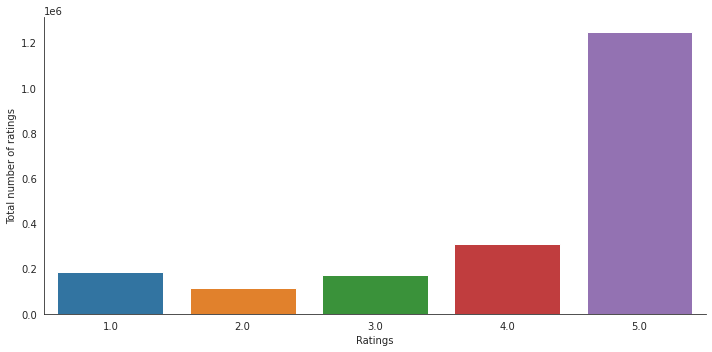

In [3]:

# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")



In [4]:
data.drop(['Timestamp'], axis=1,inplace=True)

In [5]:
#Sparsity of the dataset. The sparsity is found by dividing the total number of ratings to the product of unique users and products available in the dataset.
total_unique_products = data["ProductId"].nunique()
total_unique_users =  data["userId"].nunique()
total_unique_ratings =  data["Ratings"].count()
print(total_unique_products)
print(total_unique_ratings)
print(total_unique_users)
sparsity = 1 - (total_unique_ratings/(total_unique_users * total_unique_products))
print(sparsity)

249274
2023070
1210271
0.999993294189133


In [6]:
rated_products = data.groupby(by='userId',as_index=False)['Ratings'].count()
print(rated_products)
rated_products = rated_products[rated_products['Ratings'] < 20]
new_dataset = data.loc[~((data.userId.isin(rated_products['userId']))),:]
no_of_rated_products_per_user = new_dataset.groupby(by='userId')['Ratings'].count().sort_values(ascending=False)
print(no_of_rated_products_per_user)
print(new_dataset.ProductId.nunique())
print(new_dataset.userId.nunique())

                        userId  Ratings
0        A00008821J0F472NDY6A2        1
1        A000186437REL8X2RW8UW        1
2         A0002574WYJMBWKNCPY8        1
3        A00029263J863WSR0TDRS        1
4         A00031961JI1CBNV98TW        1
...                        ...      ...
1210266          AZZZLZXCEE4WK        2
1210267          AZZZMSZI9LKE6        4
1210268          AZZZO4QCZROW8        1
1210269          AZZZRS1YZ8HVP        1
1210270          AZZZU2TD7Q3ET        1

[1210271 rows x 2 columns]
userId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
A2ZLKIA9YLK1A9     20
AA1ZYCEKJGG3A      20
A2ZFJY6P72SC1U     20
A1Y7TIDOJ90CCW     20
AHXWPY977L7VF      20
Name: Ratings, Length: 2826, dtype: int64
42042
2826


In [7]:
n_users = len(new_dataset.userId.unique())
n_products =  len(new_dataset.ProductId.unique())
n_latent_factors = 50
data.head()

,userId,ProductId,Ratings
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [9]:
def get_count_recommendation_list(pred_user):
  counts = collections.Counter(c for l in pred_user for c in l)
  return dict(counts)

In [50]:
from collections import defaultdict
from typing import List
import scipy.sparse as sp
from scipy.stats import entropy
from functools import reduce
from math import log, e

def get_customer_satisfaction(pred_u,k):
  edt = {}
  rating_list = defaultdict(list)
  pred = pred_u.copy().groupby(['userId'])
  for userId in pred.groups.keys():
    sorted_pred_group = pred.get_group(userId).sort_values(['predicted_rating'], ascending = False)
    top_k = sorted_pred_group[:k]
    top_k_g = top_k.groupby(by='userId')
    for userId in top_k_g.groups.keys():
      top_k_user_list = top_k_g.get_group(userId)
      for _, groups in top_k_user_list.iterrows():
        diff_ratings = groups['predicted_rating'] - groups['ratings']
        rating_list.setdefault(groups['userId'], []).append(diff_ratings)
      edt[userId] = (np.sum(rating_list.get(userId)))
  #def predict_reco_list(row):
  #  if row['userId'] in customer_satisfaction.keys():
  #    return customer_satisfaction.get(row['userId'])

  #predicted['customer_satisfaction'] = predicted.apply(predict_reco_list, axis=1)
  #print("Average satisfaction is {}".format(np.sum(predicted['customer_satisfaction'])))
  return np.mean(list(edt.values()))

def personalization(predicted: List[list]) -> float:
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted: List[list]) -> sp.csr_matrix:
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        chunk_size = 5000
        chunks = [x for x in range(0, df.shape[0], chunk_size)]
        df = pd.concat([df.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index='index', columns='item', values='item') for i in range(0, len(chunks) - 1)])

        #df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)
    return similarity
  
def get_metrics(productList, predictions):
  
  # To calculate the prediction coverage
  cf_coverage = recmetrics.prediction_coverage(predictions, productList)
  print("The coverage score is {} \n".format(cf_coverage))

  # To calculate the novelty
  nov = new_dataset.ProductId.value_counts()
  pop = dict(nov)
  users = new_dataset['userId'].value_counts()
  cf_novelty,cf_mselfinfo_list = recmetrics.novelty(predictions, pop, len(users), 10)
  print("The novelty score is {} \n".format(cf_novelty))

  # To Calculate the average diversity
  #diversity = recmetrics.personalization(predictions.tolist())
  #print("Average diversity {} \n".format(diversity))

  # To calculate the diversity for each user and then take the average
  diversity = personalization(predictions.tolist())
  average = []
  for c in diversity.toarray():
    average.append(sum(c)/len(c))

  #print("Diversity for each user and average {} \n".format(1 - (sum(average)/diversity.shape[0])))

def get_f1_score(predictions, k):
    threshold = 4
    # First map the predictions to each user.
    user_est_rating = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        user_est_rating[uid].append((est, r_ui))

    # Then sort the predictions for each user and retrieve the k highest ones.
    f1_score = dict()
    for uid, user_ratings in user_est_rating.items():
        user_ratings.sort(key=lambda x:x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        if math.isnan(n_rel):
          print("nan value for rel") 
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        if math.isnan(n_rec_k):
          print("nan value for rel") 
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        if math.isnan(n_rel_and_rec_k):
          print("nan value for rel and rec") 
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        f1_score[uid] = 2 * ((precision * recall)/(precision+recall)) if (precision + recall) != 0 else 0
    return f1_score

def get_f1_score_nn(predictions, k):
    threshold = 4
    # First map the predictions to each user.
    user_est_rating = defaultdict(list)
    #for uid, iid, r_ui, est in predictions:
    #    user_est_rating[uid].append((est, r_ui))
    for index, row in predictions.iterrows():
        user_est_rating[row['userId']].append((row['predicted_rating'], row['ratings']))
    # Then sort the predictions for each user and retrieve the k highest ones.
    f1_score = dict()
    for uid, user_ratings in user_est_rating.items():
        user_ratings.sort(key=lambda x:x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)
        if math.isnan(n_rel):
          print("nan value for rel") 
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        if math.isnan(n_rec_k):
          print("nan value for rel") 
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        if math.isnan(n_rel_and_rec_k):
          print("nan value for rel and rec") 
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        f1_score[uid] = 2 * ((precision * recall)/(precision+recall)) if (precision + recall) != 0 else 0
    return f1_score
  
def get_shannon_entropy(predictions, product_list, l_recommendation_items, no_of_recommendations):
  counts = get_count_recommendation_list(predictions['cf_predictions'])
  entropy_users = {}
  pi = list()
  column_name = 'entropy_' + str(no_of_recommendations)
  for userId, row in predictions.iterrows():
    for product in row['cf_predictions']:
      pi.append(counts.get(product)/l_recommendation_items)
    predictions[column_name] = entropy(pi)
    pi.clear()
  print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(no_of_recommendations, np.mean(predictions[column_name])))

def get_shannon_entropy_d(predictions, product_list, l_recommendation_items, no_of_recommendations):
  #counts = get_count_recommendation_list(predictions['cf_predictions'])
  recommendation_items = list(np.concatenate(predictions['cf_predictions']).flat)
  print("length of recommendation items" , len(recommendation_items))
  #count_recommendation_items = collections.Counter(recommendation_items)
  product,counts = np.unique(recommendation_items, return_counts=True)
  norm_counts = counts / counts.sum()
  #print("total_count", np.sum(list(count_recommendation_items.values())))
  pi = list()
  #for product in product_list:
  #  if product in count_recommendation_items.keys():
  #    pi.append(count_recommendation_items.get(product)/len(recommendation_items))
  entropy_users = entropy(norm_counts)
  #print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(-np.sum(pi*np.log2(pi)), no_of_recommendations))
  print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(entropy_users, no_of_recommendations))

def get_shannon_entropy_new(predictions, product_list, l_recommendation_items, no_of_recommendations,product_rating):
  counts = get_count_recommendation_list(predictions['cf_predictions'])
  #count_recommendation_items = collections.Counter(recommendation_items)
  ent = 0
  for product in product_list:
    if product in counts.keys():
      pi = (counts.get(product)/l_recommendation_items) / product_rating.get(product)
      ent -= pi * log(pi,2)
      
  #entropy_users = entropy(norm_counts)
  #print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(-np.sum(pi*np.log2(pi)), no_of_recommendations))
  print("Average diversity using shannon entropy for {} no of recommendations is {} \n".format(ent, no_of_recommendations))

In [11]:
def get_users_predictions(userId, n, model):
    recommended_items = pd.DataFrame(model.loc[userId])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()


def get_top_n(pred, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    predictions = pred.copy()
    top_n = defaultdict(list)
    for idx, userId, productId, true_r, est in predictions.itertuples():
        top_n[userId].append((productId, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for userId, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[userId] = user_ratings[:n]

    ratings = {}
    for uid, user_ratings in top_n.items():
      iid_list = []
      for iid, _ in user_ratings:
        iid_list.append(iid)
      ratings[uid] = iid_list
    
    def predict_reco_list(row):
      if row['userId'] in ratings.keys():
        return ratings.get(row['userId'])

    predictions['cf_predictions'] = predictions.apply(predict_reco_list, axis=1)
    return predictions


In [28]:
def cal_f1(test_pred, no_of_recommendations):
  results=[] 
  for i in no_of_recommendations:  
     f1_score = get_f1_score(test_pred, k=i)
     for uid,score in f1_score.items():
       if math.isnan(score):
         print("nan value for uid {} value {}".format(uid, score) ) 
     average_f1_score = sum(score for score in f1_score.values())/ len(f1_score)
     results.append(average_f1_score)
  return results
def cal_f1_nn(test_pred, no_of_recommendations):
  results=[] 
  for i in no_of_recommendations:  
     f1_score = get_f1_score_nn(test_pred, k=i)
     for uid,score in f1_score.items():
       if math.isnan(score):
         print("nan value for uid {} value {}".format(uid, score) ) 
     average_f1_score = sum(score for score in f1_score.values())/ len(f1_score)
     results.append(average_f1_score)
  return results

In [13]:
!pip install scikit-surprise
# !conda install -y -c conda-forge scikit-surprise # If you use conda on a non-Colab environment

In [14]:
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
no_of_factors = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
no_of_recommendations = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

reader = Reader()
ratings_dataset = Dataset.load_from_df(new_dataset[['userId', 'ProductId', 'Ratings']],reader)
trainset, testset = train_test_split(ratings_dataset, test_size=0.2,random_state=100)
mae_svd = list()
for i in no_of_factors:
  algo = SVD(n_factors=i)
  algo.fit(trainset)
  test_pred = algo.test(testset)
  mae_svd.append(accuracy.mae(test_pred))
  print("Mean Absolute Error for value k {} is ".format(i), accuracy.mae(test_pred))
svd_f1_score = cal_f1(test_pred, no_of_recommendations)

MAE:  0.8016
MAE:  0.8016
Mean Absolute Error for value k 5 is  0.8016440254894206
MAE:  0.8022
MAE:  0.8022
Mean Absolute Error for value k 10 is  0.8021750022821007
MAE:  0.8026
MAE:  0.8026
Mean Absolute Error for value k 20 is  0.8026460357543195
MAE:  0.8040
MAE:  0.8040
Mean Absolute Error for value k 30 is  0.8039507157349176
MAE:  0.8052
MAE:  0.8052
Mean Absolute Error for value k 40 is  0.805217545488186
MAE:  0.8051
MAE:  0.8051
Mean Absolute Error for value k 50 is  0.8051170709844779
MAE:  0.8063
MAE:  0.8063
Mean Absolute Error for value k 60 is  0.806264136871152
MAE:  0.8062
MAE:  0.8062
Mean Absolute Error for value k 70 is  0.8062059689529771
MAE:  0.8072
MAE:  0.8072
Mean Absolute Error for value k 80 is  0.8072169020660449
MAE:  0.8090
MAE:  0.8090
Mean Absolute Error for value k 90 is  0.8090131961810293
MAE:  0.8087
MAE:  0.8087
Mean Absolute Error for value k 100 is  0.8086937280499747


In [36]:
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import train_test_split
k = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
no_of_recommendations = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

mae_knn = list()
for i in k:
  algo = KNNWithMeans(k=i, sim_options={'name':'pearson','user_based': True})
  algo.fit(trainset)
  test_pred = algo.test(testset)
  mae_knn.append(accuracy.mae(test_pred))
  print("Mean Absolute Error for value k {} is ".format(i), accuracy.mae(test_pred))
knn_f1_score = cal_f1(test_pred, no_of_recommendations)

Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8553
MAE:  0.8553
Mean Absolute Error for value k 5 is  0.8552804076599626
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8532
MAE:  0.8532
Mean Absolute Error for value k 10 is  0.8532044799597551
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 20 is  0.8525444677652285
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 30 is  0.8525168677863482
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 40 is  0.8525103655838698
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.8525
MAE:  0.8525
Mean Absolute Error for value k 50 is  0.8525056536269909
Computing the pearson similarity ma

In [68]:
from scipy import sparse
from tqdm import tqdm

def get_predictions(predictions, no_of_recommendations):
  pred_user = predictions.copy().groupby('userId', as_index=False)['productId'].agg({'ratings': (lambda x: list(set(x)))})
  pred_user = pred_user.set_index("userId")
  chunk_size = 5000
  chunks = [x for x in range(0, predictions.shape[0], chunk_size)]
  #model = pd.DataFrame()

  for i in tqdm(range(0, len(chunks) - 1)):
    chunk_df = predictions.iloc[ chunks[i]:chunks[i + 1] - 1]
    interactions = (chunk_df.groupby(['userId', 'productId'])['ratings']
      .sum()
      .unstack()
      .reset_index()
      .fillna(0)
      .set_index('userId')
    )
    model = model.append(interactions, sort=False) 
    
  #model = predictions.concat([predictions.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index='userId', columns='productId', values='ratings') for i in range(0, len(chunks) - 1)])
  chunk_size = 5000
  chunks = [x for x in range(0, df.shape[0], chunk_size)]
  model = predictions.concat([predictions.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index='userId', columns='productId', values='ratings') for i in range(0, len(chunks) - 1)])
  #model = predictions.pivot_table(index='userId', columns='productId', values='ratings').fillna(0)
  cf_recs = [] = []
  for user in pred_user.index:
    cf_predictions = get_users_predictions(user, no_of_recommendations, model)
    cf_recs.append(cf_predictions)
  pred_user['cf_predictions'] = cf_recs
  return pred_user

In [17]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

train_user_ids = np.array([one_hot(d,10) for d in train['userId']])
train_product_ids = np.array([one_hot(d,10) for d in train['ProductId']])
test_product_ids = np.array([one_hot(d,10) for d in test['ProductId']])
test_user_ids = np.array([one_hot(d,10) for d in test['userId']])
#train_user_ids = user_encoder.fit_transform(train.userId)
#train_product_ids = product_encoder.fit_transform(train.ProductId)
#test_user_ids = user_encoder.fit_transform(test.userId)
#test_product_ids = product_encoder.fit_transform(test.ProductId)

In [18]:
num_users= train_user_ids.max()+1
num_products = train_product_ids.max() + 1

In [19]:
from keras.layers.normalization.batch_normalization import BatchNormalization
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, dot

def get_ncf_model(no_of_factors):

  product_input = Input(shape = [1], name = "Product-Input")
  user_input = Input(shape = [1], name = "User-Input")



  # Product embedding for GMF
  gmf_product_embedding = Embedding(n_products, no_of_factors, name= "GMF-Product-Embedding")(product_input)
  

  # User embedding for GMF
  gmf_user_embedding = Embedding(n_users, no_of_factors, name = "GMF-User-Embedding")(user_input)
  
  # GMF layers
  gmf_product_vec = Flatten(name = "GMF-Flatten-Products")(gmf_product_embedding)
  gmf_user_vec = Flatten(name = "GMF-Flatten-Users")(gmf_user_embedding)
  gmf_output = Multiply()([gmf_user_vec, gmf_product_vec])

  
  # Product embedding for MLP
  mlp_product_embedding = Embedding(num_products, no_of_factors, name= "MLP-Product-Embedding")(product_input)
  

  # User embedding for MLP
  mlp_user_embedding = Embedding(num_users, no_of_factors, name = "MLP-User-Embedding")(user_input)

  # MLP layers

  mlp_product_vec = Flatten(name = "MLP-Flatten-Products")(mlp_product_embedding)
  mlp_user_vec = Flatten(name = "MLP-Flatten-Users")(mlp_user_embedding)

  #Concatenate features
  conc = Concatenate()([mlp_user_vec, mlp_product_vec])

  fc1 = Dropout(0.2)(conc)
  fc2 = Dense(64, activation='relu')(fc1)
  fc3 = BatchNormalization()(fc2)
  fc4 = Dropout(0.2)(fc3)
  fc5 = Dense(32, activation='relu')(fc4)
  fc6 = BatchNormalization()(fc5)
  fc7 = Dropout(0.2)(fc6)

  fc8 = Dense(16, activation='relu')(fc7)
  fc9 = Dense(8, activation='relu')(fc8)
  final_conc = Concatenate()([gmf_output, fc9])
  output = Dense(1, activation='relu')(final_conc)

  #Create model and compile it
  model = Model([user_input, product_input], output)
  model.compile('adam', 'mean_absolute_error')
  return model

In [38]:
print(nn_f1_score)

[0.7748577038675216, 0.7757411177306404, 0.7758605199184256, 0.7758953188516718, 0.7759155780123695, 0.7759215751598872, 0.7759241447653993, 0.7759252533788523, 0.775925910626847, 0.7759260733000611, 0.7759261028847333, 0.7759261028847333]


In [20]:
no_of_factors = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mae_ncf = list()
for k in no_of_factors:
  model = get_ncf_model(k)
  model.fit([train_user_ids, train_product_ids], train['Ratings'], epochs=3)
  predicton = model.predict([test_user_ids, test_product_ids])
  mae_ncf.append(mean_absolute_error(test['Ratings'], predicton))
  print("Mean Absolute Error for value k {} is ".format(k), mean_absolute_error(test['Ratings'], predicton))

2022-04-14 07:14:33.647198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 07:14:33.749304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 07:14:33.750097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 07:14:33.751536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/3
50577/50577 [==============================] - 272s 5ms/step - loss: 0.8700
Epoch 2/3
50577/50577 [==============================] - 269s 5ms/step - loss: 0.8545
Epoch 3/3
50577/50577 [==============================] - 268s 5ms/step - loss: 0.8542
Mean Absolute Error for value k 5 is  0.8475349820779112
Epoch 1/3
50577/50577 [==============================] - 276s 5ms/step - loss: 0.8725
Epoch 2/3
50577/50577 [==============================] - 277s 5ms/step - loss: 0.8554
Epoch 3/3
50577/50577 [==============================] - 277s 5ms/step - loss: 0.8551
Mean Absolute Error for value k 10 is  0.8490472632362808
Epoch 1/3
50577/50577 [==============================] - 279s 5ms/step - loss: 0.8716
Epoch 2/3
50577/50577 [==============================] - 277s 5ms/step - loss: 0.8567
Epoch 3/3
50577/50577 [==============================] - 277s 5ms/step - loss: 0.8564
Mean Absolute Error for value k 20 is  0.8497254249213528
Epoch 1/3
50577/50577 [==============================

In [39]:
no_of_recommendations = [5, 10, 20, 30, 40, 50 , 60, 70, 89, 90, 100]
prediction = model.predict([test_user_ids, test_product_ids])
predicted_df = pd.DataFrame({'userId': test['userId'], 'productId': test['ProductId'], 'ratings': test['Ratings']})
predicted_df['predicted_rating'] = prediction

nn_f1_score = cal_f1_nn(predicted_df, no_of_recommendations)

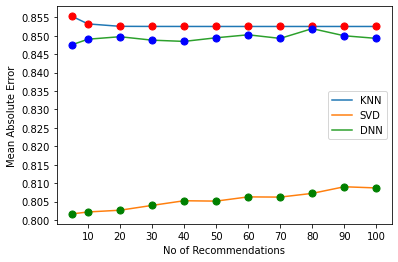

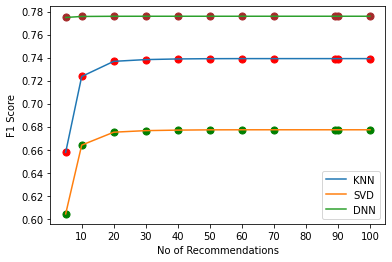

In [43]:
import matplotlib.pyplot as plt
k = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plt.xlabel('No of Recommendations')
plt.ylabel('Mean Absolute Error')
ax=plt.gca()
ax.locator_params('y', nbins=15)
plt.locator_params('x', nbins=20)
plt.plot(k, mae_knn, label = "KNN")
plt.plot(k, mae_svd, label = "SVD")
plt.plot(k, mae_ncf, label = "DNN")

plt.scatter(k,mae_knn,s=50,color='red',zorder=2)
plt.scatter(k,mae_svd,s=50,color='green',zorder=2)
plt.scatter(k,mae_ncf,s=50,color='blue',zorder=2)

plt.legend()
plt.show()
plt.xlabel('No of Recommendations')
plt.ylabel('F1 Score')
ax=plt.gca()
ax.locator_params('y', nbins=10)
plt.locator_params('x', nbins=20)
plt.scatter(no_of_recommendations,knn_f1_score,s=50,color='red',zorder=2)
plt.scatter(no_of_recommendations,svd_f1_score,s=50,color='green',zorder=2)
plt.scatter(no_of_recommendations,nn_f1_score,s=50,color='brown',zorder=2)
plt.plot(no_of_recommendations, knn_f1_score, label = "KNN")
plt.plot(no_of_recommendations, svd_f1_score, label = "SVD")
plt.plot(no_of_recommendations, nn_f1_score, label = "DNN")

plt.legend()
plt.show()

In [1]:
import functools

no_of_recommendations = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for k in no_of_recommendations:
  pred_user = get_predictions(predicted_df, k)
  l_recommendation_items = functools.reduce(lambda count, l: count + len(l), pred_user['cf_predictions'], 0)
  print("The metrics for the number of recommendations {} \n".format(k))
  get_shannon_entropy_new(pred_user, product_list, l_recommendation_items, k, product_rating)
  get_metrics(product_list, pred_user['cf_predictions'])

NameError: name 'get_predictions' is not defined